# Signature of millicharged dark matter in pulsar dispersion measure (DM): a Bayesian analysis

Notebook created for the UW 2018 Computational Physics course, module II. This project was inspired by the work of [Shao and Zhang](https://arxiv.org/abs/1705.01278) and is part of ongoing research with Diego Blas, Andrea Caputo, Miguel Frias, Paolo Pani and Lijing Shao. The ideas detailed here will appear in a future publication.

In [2]:
#Pkg.add("PyCall")
#Pkg.add("Plots")
#Pkg.add("IJulia")
#Pkg.add("StatsBase")
#Pkg.add("LinearAlgebra")
#Pkg.add("Statistics")
using Pkg
using Plots
using PyCall
using StatsBase
using LinearAlgebra
using Statistics

In [3]:
@pyimport numpy as nup
nup.inf

Inf

## Introduction, data and paramters

We want to test a model for the dispersion measure of pulsars (DM). The model includes an astrophysical and a dark matter contribution
\begin{equation}
DM=DM_{\text{astro}}+DM_{\text{dm}} \, .
\end{equation}

For the astrophysical contribution, we know
\begin{equation}
DM_{\text{astro}}= n_e d \, ,
\end{equation}
where $n_e$ is the electron density, estimated through the [YMW16](http://119.78.162.254/dmodel/) electron-density model, and $d$ is the distance determined with parallax.

For the dark matter contribution, we assume milli-charged dark matter of mass $m_{\text{dm}}$ and charge $q=e \epsilon$,
\begin{equation}
DM_{\text{dm}}= m_e \frac{\epsilon^2}{m_{\text{dm}}^2} \rho d \, ,
\end{equation}
where $\rho$ is the dark matter energy density of the Milky Way, assumed to be uniform.

To make the large uncertainty in d count, we use a model in which $x=DM$, $y=d$, so that
\begin{equation}
y = x / (n_e + m_e \frac{\epsilon^2}{m_{\text{dm}}^2} \rho)
\end{equation}

We first upload the data set provided by the [ATNF pulsar catalogue](http://www.atnf.csiro.au/research/pulsar/psrcat/). The pulsars used here are the ones for which we have parallax distance (for most pulsars distance is estimated via the DM itself); we also pick the pulsars that are expected to give the strongest constraints, for having the smallest value of the ratio DM/d.

In [4]:
function get_data()
#n     PX       PXerr       DM        DMerr         ne
# when the error was missing I set it to the last digit    
datatable= """
2     0.770     2.3e-01     6.4778     6.0e-04     0.009036
4     0.710     1.7e-01     9.02314     7.0e-05     0.007827
5     0.300     1.0e-01     22.177     5.0e-03     0.004931
6     0.700     2.0e-01     10.7645     1.5e-03     0.008292
7     2.530     7.0e-02     3.13695     0.01     0.020564
9     0.810     3.0e-02     10.3932     0.01     0.016935
10     2.770     7.0e-02     3.18321     1.6e-04     0.015919
11     0.370     1.2e-01     24.63109     1.8e-04     0.012689
12     0.470     3.0e-02     19.6191     3.0e-04     0.004691
13     0.400     2.0e-01     23.92344     9.0e-05     0.011004
15     0.860     1.8e-01     11.61944     2.0e-05     0.009608
16     4.200     1.4e+00     2.38     1.9e-01     0.009246
18     0.930     8.0e-02     10.922     6.0e-03     0.008167
19     0.731     2.2e-02     14.325     1.0e-02     0.008209
20     1.160     8.0e-02     9.25159     5.3e-04     0.008940
"""
#14     0.160     9.0e-02     61.25     5.0e-03     0.003488
#1     0.130     2.0e-02     34.9758     1.6e-03     0.000062  
#8     0.600     2.0e-01     13.3140     2.5e-03     0.044781  
#3     0.213     0.001     24.37     3.0e-03     0.000836    
#17     0.900     4.0e-01     11.10816     1.1e-04     0.024026  
    
    lines = split(datatable, '\n')
    lines = filter(x->(length(x)>0), lines)
    lines = filter(x->(length(x)>0), lines)

    x = zeros(length(lines))
    DM = zeros(length(lines))
    DMerr = zeros(length(lines))
    xerr = zeros(length(lines))
    ne = zeros(length(lines))
    for (i,line) in enumerate(lines)
        words = split(line, "     ")
        x[i] = 10^(-3)* parse(Float64, words[2]) # parallax in as
        DM[i] = parse(Float64, words[4])      # DM in cm^-3 pc
        DMerr[i] = parse(Float64, words[5])    # DM err
        xerr[i] = 10^(-3)* parse(Float64, words[3])   # parallax err
        ne[i] = parse(Float64, words[6])   # electron density cm^-3
    end
    return x,DM,xerr,DMerr,ne
end;

In [5]:
x,DM,xerr,DMerr,ne = get_data();  #uploading the data

We define the main parameters, and set the units straight:
we define the dark matter density, the distance (from the parallax) and its error, the electron mass.

In [6]:
const rho = 0.3 * 10^9  # DM energy density (eV cm^-3)
d =1 ./x      # distance (pc)
derr =  d .* xerr ./ x   # distance error (pc);
const m_e = 0.5109989461 * 10^6   # electron mass in eV

510998.94609999994

We can visualize the data, the $DM_astro$ contribution and a proposal for $DM_{dm}$. We define $r^2=\frac{\epsilon^2}{m_{\text{dm}}^2}$.

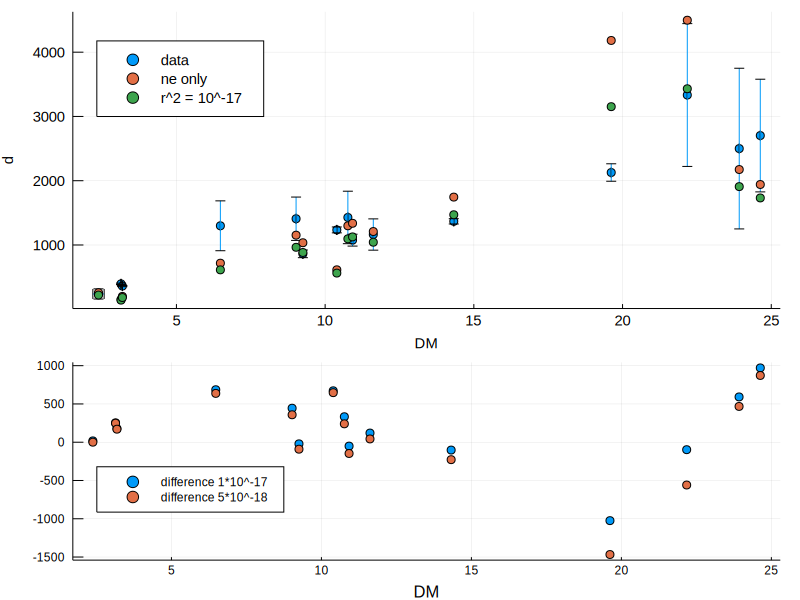

In [7]:
pp=scatter(DM, d, xerr=DMerr, yerr=derr, label="data",xlabel="DM", ylabel="d", legend=:topleft, 
    dpi=500, titlefont=10, guidefont=10, tickfont=10, legendfont=10, size=(600,400)) 
savefig("datadDm.png")
scatter!(DM, DM ./ ne , label="ne only")
scatter!(DM , DM ./ ( ne .+ m_e .* rho .* 10^-17) , label="r^2 = 10^-17")
p1=scatter!()
scatter(DM , d .- DM ./ ( ne .+ m_e .* rho .* 1*10^-17), label="difference 1*10^-17", xlabel="DM", legend=:bottomleft)
scatter!(DM , d .- DM ./ ( ne .+ m_e .* rho .* 5*10^-18), label="difference 5*10^-18")
p2=scatter!()
plot(p1, p2, layout=grid(2,1,heights=[0.6,0.4]) ,size = (800, 600) )

The model describes the data reasonably well for small values of the ratio $\frac{\epsilon^2}{m_{\text{dm}}^2}\sim 10^{-17}-10^{-18}$.

The dark matter contribution is necessarily positive, like the electron density contribution. Therefore, the dark matter model provides an improvement only when the electron density was over-estimating the distance. 

We can now proceed to a Bayesian analysis of the model for the data. 


## The emcee ensamble sampler

The code to follow is adaptated from the tutorial session 3 of the data analysis course module. 

We use the emcee sampler:

In [8]:
function ensemble_sampler(logprob_func, initial, nsteps)
    # A translation of the "emcee" ensemble sampler by Dan Foreman-Mackey,
    # http://arxiv.org/abs/1202.3665.  This is "Algorithm 3" in that paper.
    #
    # *logprob_func* is a log-posterior-probability function of the parameters.
    # *initial* must be an array with shape (Nwalkers, Nparams)
    # *nsteps* is the desired number of MCMC steps to take
    #
    nwalkers, nparams = size(initial)
    if (nwalkers % 2 != 0)
        println("NWalkers must be even")
        return
    end
    chain = zeros((nsteps, nwalkers, nparams))
    logprobs = zeros(nwalkers)
    nhalf = Int(nwalkers/2)
    # Start at initial parameter values
    params = initial
    for j in 1:nwalkers
        logprobs[j] = logprob_func(params[j,:])
    end
    # "Stretch move" parameter
    alpha = 2.
    # Tried moves
    tries = 0
    # Accepted moves
    accepts = 0
    for i in 1:nsteps
        # At each step, we first update one half of the ensemble (holding the other half fixed)
        # and then updated the second half (holding the first half, with its updated values, fixed)
        for half in 0:1
            for j in 1:nhalf
                # We're going to update the walker at index "me":
                me = half*nhalf + j
                # Draw a walker from the other half of the walkers
                other = (1-half)*nhalf + rand(1:nhalf)
                # Draw the "stretch move" distance
                z = ((alpha - 1.) * rand(Float64) + 1)^2 / alpha
                # Compute the parameter value -- it is along the line connecting "me" and "other"
                params_new = params[other,:] .+ z .* (params[me,:] - params[other,:])
                # Compute the log-prob at the new sample location
                logprob_new = logprob_func(params_new)
                # There is an extra term that weights the proposal distribution -- required to maintain
                # detailed balance.
                logproposal = (nparams-1) * log(z)
                tries += 1
                # Keep this new sample?
                if exp(logproposal + logprob_new - logprobs[me]) >= rand(Float64)
                    # Keep it!
                    params[me,:] = params_new
                    logprobs[me] = logprob_new
                    accepts += 1
                end
                # Record the chosen parameter values
                chain[i, me, :] .= params[me, :]
            end
        end
    end
    return chain, accepts/tries
end;

We still need to define the log likelihood, the prior and the posterior. 

We choose as a parameter $\log_{10}(\frac{\epsilon^2}{m_{\text{dm}}^2}) $.

We define a Gaussian likelihood and a flat prior. The range of the prior is particularly important as the result seems to depend on it rather strongly. The range is based on the fact that an effect mimicking a mass of the photon has a lower bound (determined by the Heisenberg uncertainty principle and the age of the Universe, see [JDBarrow](https://www.nature.com/articles/307014a0)) and an upper bound (introduced by the approximations made to obtain the formula for the DM). 
\begin{equation}
P(\log_{10}(\frac{\epsilon^2}{m_{\text{dm}}^2})) = \begin{cases}
1 / \text{range} \quad \text{if} \ -36<\log_{10}(\frac{\epsilon^2}{m_{\text{dm}}^2})<-9 \\
0 \quad \text{otherwise}
\end{cases}
\end{equation}

In [9]:
function mymodel_log_likelihood(x, y, sigma, ratioepsilondmsq, ne)  
    return -0.5 * sum(@. (y - x / (ne + m_e * rho * 10^(ratioepsilondmsq) ) )^2 / sigma^2)   #Gaussiana likelihood
end;

function good_mymodel_lnl(pars)   #adapted to out paramters
    ratioepsilondmsq = pars
    mymodel_log_likelihood(DM, d, derr, ratioepsilondmsq, ne)
end;

function good_mymodel_logprob(pars)   #flat prior in a finite range:
    ratioepsilondmsq = pars[1]
    logposterior =  if -36 < ratioepsilondmsq < -9 return 0.0 else return -nup.inf end #-10^-13 < ratioepsilondmsq < 10^-13
   # logposterior = 0. # -30 <
    return logposterior + good_mymodel_lnl(pars)
        end;

We initialize the sampler. The sampler is not too sensitive to the initial value of the parameter. The jump size must be tailored to the expected parameter, so that the interesting range is explored. 

In [10]:
initial = [-20]  # initial guess for the paramters

jumpsizes = ones(length(initial)) * 1e-6   
nparams = length(initial)

nwalkers = 20  # nwalker >> nparams

walkers = zeros((nwalkers, nparams)) 
for i in 1:nwalkers    # We initialize the walkers in a ball around the *initial* location.
    walkers[i,:] = initial + randn(nparams) .* jumpsizes
end

# Call the sampler!
nsteps = 10_000   
chain,acceptance = ensemble_sampler(good_mymodel_logprob, walkers, nsteps)
acceptance

0.828575

## Results

We plot the parameter value along a fraction of the walkers' steps.

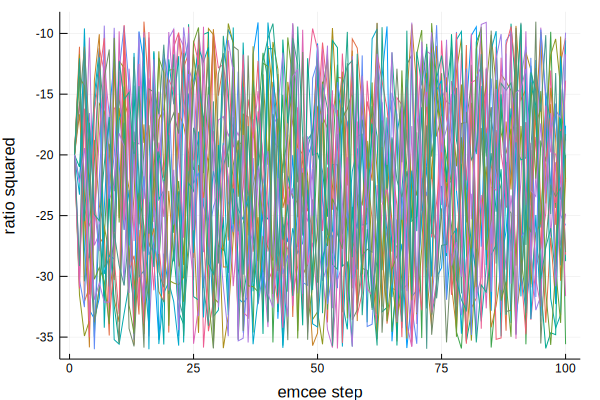

In [11]:
burnin = 1#1_000
plot(chain[burnin:100:end,:,1], legend=false, ylabel="ratio squared", xlabel="emcee step") #yaxis=:log

The walkers explor the parameter space succesfully. The density of this exploration mirrors the uncertainity of the parameter.

We also plot a histogram of the paramter value across the sample.

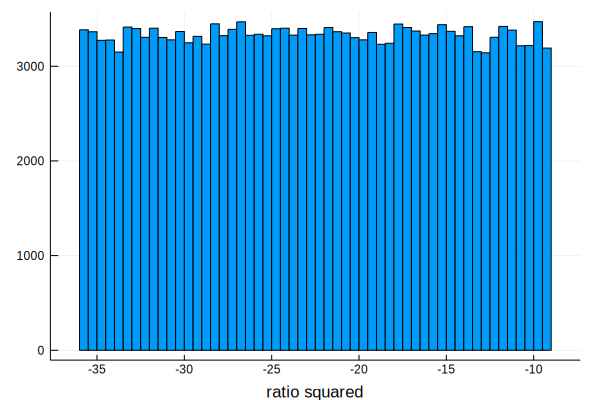

In [12]:
burnin = 1_000
flat = chain[burnin:end,:,:]
nb,nw,np = size(flat)
flat = reshape(flat, (nb*nw,np));
histogram(flat[:,1], xlabel="ratio squared", label="")

The parameter is very broadly distributed in the allowed range.

We can find the paramter's mean and standard deviation over the sample (after the initial stage) and compare it with the data. 

In [13]:
mean_ratiosqp, std_ratiosqp = mean(flat[:,1]), std(flat[:,1])

(-22.51422117803513, 7.775634100119404)

In [14]:
mean_ratiosq, std_ratiosq =10^(mean_ratiosqp), 10^(mean_ratiosqp) * log(10) * std_ratiosqp

(3.0604044301554964e-23, 5.479366199401713e-22)

From the following visualization is easier to see that $r^2=\frac{\epsilon^2}{m_{\text{dm}}^2}$ is consistent with zero (i.e. no dark matter), with the uncertainty provided by the sample.

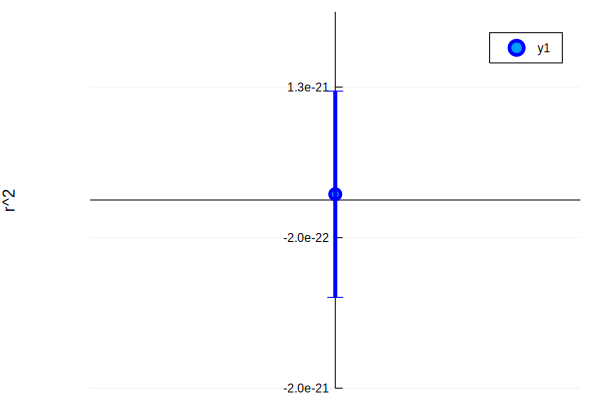

In [15]:
scatter((0, mean_ratiosq), xlims=(-0.1,0.1), ylims=(-10^-21,10^-21),
    yerr= std_ratiosq,
    yticks = -10^-21:( 8* 10^-22 ):10^-21,
    framestyle=:origin,
    xticks=:false, yformatter = y -> convert(Float64,round(3*rand()*y, digits=22)),
    linecolor=:blue, ylabel="r^2", markerstrokewidth=4, markerstrokecolor=:blue) #, yaxis=:log

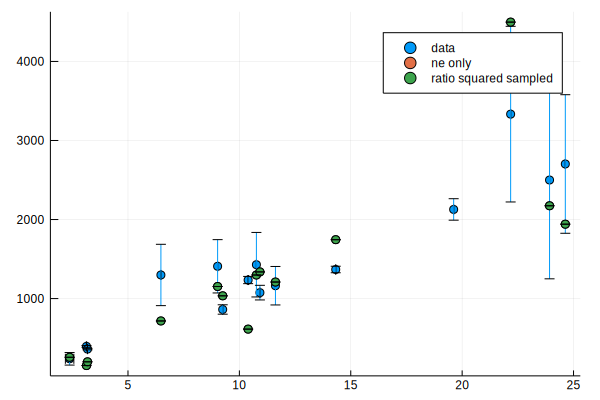

In [20]:
ppl2=scatter(DM, d, xerr=DMerr, yerr=derr, label="data") #xerr=derr,
scatter!(DM , DM ./ ne, label="ne only")
scatter!(DM , DM ./ ( ne .+ m_e .* rho .* mean_ratiosq ) , yerr=std_ratiosq, label="ratio squared sampled")

In [22]:
plot(ppl2, dpi=500, size=(600,400))
savefig("dataandfitmodel.png")

Finally, we can use the sampled parameter to constraint the $\epsilon - m_{\text{dm}}$ parameter space of the dark matter model.

In [16]:
mean_ratio, std_ratio = sqrt(mean_ratiosq), 1. / (2 * sqrt(mean_ratiosq)) * std_ratiosq

(6.020499670735847e-12, 5.415398003853584e-11)

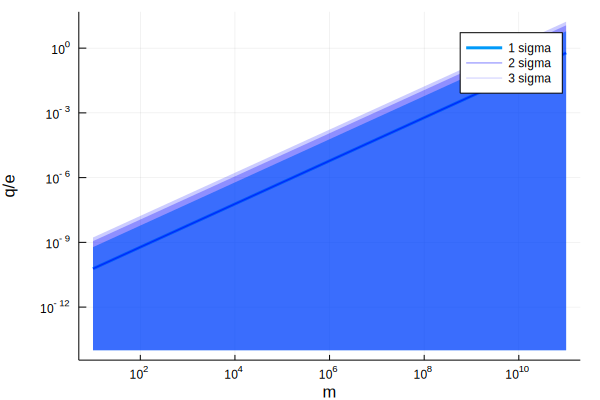

In [17]:
mdm=zeros(11)
eps=zeros(11)
ribbon=zeros(11)
lowerribbon=zeros(11)

for i in 1:11
    mdm[i]=10^i
    eps[i]=mdm[i]*mean_ratio
    ribbon[i]= mdm[i] * std_ratio * cos(atan(mean_ratio))
    lowerribbon[i]= eps[i] - 10^-14
end

plot(mdm, eps, xaxis=:log, yaxis=:log, ribbon=(lowerribbon,ribbon),
    fillalpha=.6, xlabel="m", ylabel="q/e", label="1 sigma", linewidth=3)  
plot!(mdm, eps, xaxis=:log, yaxis=:log, ribbon=(lowerribbon,2 .* ribbon),
    color=:blue, fillalpha=.3, xlabel="m", ylabel="q/e", label="2 sigma", linealpha=.5)
plot!(mdm, eps, xaxis=:log, yaxis=:log, ribbon=(lowerribbon,3 .* ribbon),
    color=:blue, fillalpha=.2, xlabel="m", ylabel="q/e", label="3 sigma", linealpha=.2)

The plot above shows the region in the millicharged dark matter paramter space that is consistent with the data analysed, at 1, 2 and 3 $\sigma$. The outside region is excluded at the corresponding uncertainty level.

We can compare our bound with existing bounds in the literature, e.g. [Kavanagh](https://arxiv.org/abs/1810.00033) and [McDermott et al](https://arxiv.org/abs/1011.2907). To make this notebook self contained, we copy the data here directly.

In [18]:
function get_constraint()
datatable= "3.7704533941535283  2.228513445183611e-14
5.66051970887374  2.179363712514282e-14
8.497978842890141  2.1432141009139565e-14
12.757477476718126  2.1432141009139565e-14
19.15199303010012  2.1432141009139565e-14
28.75100074248579  2.179363712514282e-14
97.28267490103568  2.057352595009201e-14
146.0443191104445  2.057352595009201e-14
219.2470875840018  2.057352595009201e-14
329.1417681074956  2.057352595009201e-14
494.11969256568267  2.057352595009201e-14
753.2474173903199  2.1519949155557936e-14
1078.8602327134975  2.1122630025160888e-14
1671.78204580875  2.057352595009201e-14
2509.7405147378972  2.057352595009201e-14
3767.714497896596  2.057352595009201e-14
5655.995615577816  2.1194481005540757e-14
7883.9785210905075  2.6293578961190713e-14
8783.13030618252  1.9495498216783907e-13
8705.694725416568  5.801912636891173e-14
8642.187604713687  3.798928919424407e-14
8629.577179864444  1.0776067768946912e-13
10741.261431954345  7.489105838662991e-13
10934.966961179154  1.1449988366724278e-12
12207.388052201768  1.9288713728739597e-12
11162.763967325429  2.4662443682801355e-13
15040.601387907904  2.9363242568957065e-12
19346.386150690305  4.635414834466519e-12
24127.551843561232  7.995512927686314e-12
29341.24751491079  1.4046549175772873e-11
35889.9965667282  3.5356269022221625e-11
32981.03649555224  2.1301899816540124e-11
40596.24866469408  6.477450366001843e-11
44220.81464646161  1.0396232306132001e-10
49732.27939400692  1.7565913018301282e-10
59964.36618901322  2.9933518849871273e-10
79550.73356517266  1.5307167603819663e-9
75319.12663672218  9.010452475877855e-10
73972.21392658912  6.661060250389643e-10
126183.23454531301  1.968336461606968e-9
546161.2716845659  2.8326196633169693e-7
501085.28928804194  1.4644317695672502e-7
501410.45936348924  9.215303293865368e-8
839124.3235028381  4.3129287734484765e-7
1259009.5969916768  6.467349355069615e-7
1888999.1875104825  9.697959293465487e-7
2834226.1559733446  0.0000014542343283804472
4252430.576103075  0.0000021806623618899685
6380283.297599475  0.0000032699601733782674
9572906.644516753  0.000004894286293614519
14363046.093385253  0.000007339110142369721
21550099.749366544  0.000011005187365542475
32333447.667589508  0.000016502565924373596
48512621.76192386  0.000024746028671986504
72787612.82777064  0.000037107316391952
109209730.97536847  0.000055540074001060034
163856648.57014877  0.00008328379174323178
245848067.20837772  0.00012488622119944583
368866766.6372992  0.00018727015087836057
553443625.7105032  0.00028029507518440857
830378546.5957093  0.0004203097869092898
1245887563.9974992  0.0006302655045063001
1869311085.2722392  0.0009450995873581978
2804679121.195226  0.0014198378113839112
4208098646.6066084  0.002129083886172109
6313751898.790346  0.003198555840708083
9473083668.009048  0.004787412439450313
14213273190.963808  0.007178850006367058
21325382724.443764  0.010764873105404225
29941078424.757805  0.015080718846622428
46840481538.115  0.02369596863706837
62334626747.1329  0.033381362501524375
86609963604.9196  0.045791462749094285
194986197594.18185  0.0979214182758584
292554377433.86847  0.14683572453887644
438945359161.84894  0.21977517643009134
658587058271.4175  0.32955861786907914
988139325857.1232  0.4923483094489083
1401097754914.2246  0.76226372878021094
1129.403324558888  0.00009815227753962711
1392.3771849356897  0.00011019385010616269
1747.3428503054745  0.00012331064345193183
2116.2772911668685  0.000140690173505551
2609.0380231252902  0.00016528273537425836
3216.534730361468  0.0001867013859581994
3965.4829020959373  0.0002003077566658291
4888.818546985832  0.00021569786031366565
6027.146598645058  0.00022943927308802825
7395.260971257174  0.000258488704136976
9160.674000727286  0.00028583925307477796"
    lines = split(datatable, "\n")
    lines = filter(x->(length(x)>0), lines)
    lines = filter(x->(length(x)>0), lines)

    mdmdata = zeros(length(lines))
    epsdata = zeros(length(lines))
    
    for (i,line) in enumerate(lines)
        words = split(line, "  ")
        mdmdata[i] =  parse(Float64, words[1]) # m_dm in eV
        epsdata[i] = parse(Float64, words[2])      # epsilon = q/e
    end
    return mdmdata,epsdata
end;

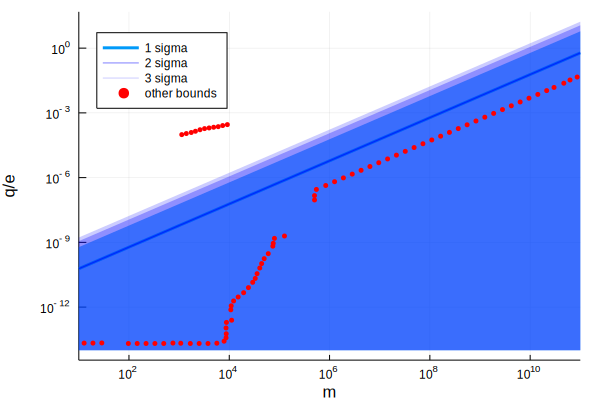

In [56]:
mdmdata,epsdata=get_constraint();

pl1=plot(mdm, eps, xaxis=:log, yaxis=:log, ribbon=(lowerribbon,ribbon),
    fillalpha=.6, xlabel="m", ylabel="q/e", label="1 sigma", linewidth=3, legend=:topleft)  
plot!(mdm, eps, xaxis=:log, yaxis=:log, ribbon=(lowerribbon,2 .* ribbon),
    color=:blue, fillalpha=.3, xlabel="m", ylabel="q/e", label="2 sigma", linealpha=.5)
plot!(mdm, eps, xaxis=:log, yaxis=:log, ribbon=(lowerribbon,3 .* ribbon),
    color=:blue, fillalpha=.2, xlabel="m", ylabel="q/e", label="3 sigma", linealpha=.2)

scatter!(mdmdata, epsdata, xaxis=:log, yaxis=:log, color=:red, linewidth=2, xlim=(10,10^11),
markerstrokecolor = :false, label="other bounds", markersize = 3)

In [82]:
plot(pl1, dpi=500, size=(600,400))
savefig("bounds.png")

The comparison with previous bounds shows that we achieve comparable constraints, but we are not able to improve them.

## Discussion and caveats

This analysis did not take into account the fact that the model for the electron density, [YMW16](http://119.78.162.254/dmodel/), is rather uncertain -- some analysis in the [literature](https://arxiv.org/abs/1705.01278) assign the electron density a $20 \%$ uncertainty. In our analysis, for simplicity, we did not take this uncertainty into account.

To improve the analysis, we could also include a larger number of pulsars, already available in the catalogue. However, we think we have already included the ones that provide the best bound, and that are the most consistent with the model.